# Reto de detención de fraude 
Procedencia: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection 

Autor: Raúl Salazar de Torres

El riesgo del fraude se encuentra presente en una inmesa cantidad de sectores. Actualmente lo podemos encontrar muy presente en el sector bancario, con un gran impacto, en el sector deportivo, sector de marketing y prácticamente en mayor o menor medida en casi todos los sectores. 

Para las empresas de marketing, el fraude basado en los clics en anuncios ocurren muy amenudo y debido al número tan grande de clics al que se encuentran sometidos el fraude ocurre con bastante frecuencia generando datos confusos, lo cual supone un desperdicio de dinero. 

Centrandonos en el objetivo del datasets, que consiste en datos de marketings, más concretamente se encuentra relacionado con clics en anuncios los diferentes canales publicitarios aumentan los costos por cada uno de los clics que se haga en el anuncio. Como ya hemos mencionado anteriormente, contamos con más de los mil millones de dispositivos móviles inteligentes que se encuentran en uso actualmente, concretamente China es el mercado de telefonía móvil más grande del mundo y por tnato, son los que más se encuentrar afectados por este tráfico fraudulento.

### Notebooks de referencia

https://www.kaggle.com/nanomathias/feature-engineering-importance-testing/notebook  
https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns  
https://www.kaggle.com/kailex/talkingdata-eda-and-class-imbalance  

### Origen del dataset

TalkingData (https://www.talkingdata.com/) es uno de los más grandes plataformas de big data. Cubre el 70% de los dispositivos activos en todo el país. Manejan 3 mil millones de clics por día, de los cuales el 90% son fraudulentos. Ellos buscan explotar estos datos para llevar a cabo la creación de listas negras de IP y dispositivos. 

### Descripción de los datos

El objetivo que se plantea consiste en predecir si un usuario descargará la app despues de clicar en un anuncio. Los datos se encuentran **anonimizados**.

#### Descripción de ficheros de datos

* **train.csv**: dataset de entrenamiento (formato .zip **1.21 GB**)
* **train_sample.csv**: Aproximadamente 100.000 filas seleccionadas aleatoriamente del conjunto de entrenamiento (formato .zip **1.08 MB**)
* **test.csv**: dataset de test (formato .zip **161.93 MB**)
* **sampleSubmission.csv**: Archivo de presentación de muestra en el formato correcto (formato .zip **40.11 MB**)

 #### Campos de datos

Cada fila  del conjunto de entrenamiento contiene un registro de clic, con las siguientes caracteristicas:

* **ip**: ip del clic
* **app**: id de app para el equipo de marketing
* **device**: id del tipo de dispotivo ( ej. iphone 6 plus, iphone 7, huawei mate 7, etc.)
* **os**: id de la versión del sistema operativo del dispositivo
* **channel**: id del canal de publicación del anuncio (Google adwords, etc.)
* **click_time**: timestamp del clic (UTC)
* **attributed_time**: si el usuario descarga la app después de clicar en el anuncio, este es el momento de descarga de la app
* **is_attributed**: aqui se encuentra nuestro objetivo para predecir, indicando si la app se descargó
        
_Debemos de tener en cuenta que ip, app, device, os y channel se encuentran anonimizados_

El conjunto de test es similar, con las siguientes diferencias:
* **click_id**: reference para hacer la predicción
* **is_attributed**: no incluido




### 1. Cargando datos

In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargando un subconjunto de entrenamiento y test
X_train = pd.read_csv('./input/train.csv', nrows=1000000, parse_dates=['click_time'])
X_test = pd.read_csv('./input/test.csv')

# Mostrando datos de conjunto de entrenamiento
X_train.head()

ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaN   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaN   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaN   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaN   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaN   

   is_attributed  
0              0  
1              0  
2              0  
3              0  
4              0

#### 1.1. Información generica del conjunto cargado

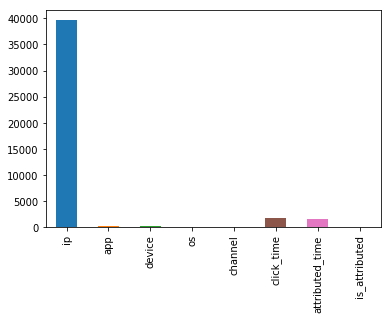

In [2]:
# contamos los elementos únicos de cada variable
t_unique = X_train.nunique()
t_unique.plot(kind='bar')

In [3]:
# Obtenemos el número de total de descargas en todo nuestro subconjunto
X_train[X_train['is_attributed']==1].count()

ip                 1693
app                1693
device             1693
os                 1693
channel            1693
click_time         1693
attributed_time    1693
is_attributed      1693
dtype: int64

### 2. Extrayendo caracteristicas

#### 2.1. Extracción de información temporal
Llevaremos a cabo la extracción de día, minuto, hora y segundo del momento de clicado

In [4]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaN   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaN   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaN   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaN   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaN   

   is_attributed  day  hour  minute  second  
0              0    6    14      32      21  
1              0    6    14      33      34  
2              0    6    14      34      12  
3              0    6    14      34      52  
4              0    6    14      35       8

A continuación vamos a extraer la diferencia de tiempo existente entre el momento de la descarga y el momento del clic

In [5]:
X_train['click_time'] = pd.to_datetime(X_train['click_time'])
X_train['attributed_time'] = pd.to_datetime(X_train['attributed_time'])
X_train['timePass']= X_train['attributed_time']-X_train['click_time']

# Convertimos timePass to float y comparamos que todos los tipos son adecuados para llevar a cabo el algoritmo
X_train['timePass'] = X_train['timePass'].dt.total_seconds()

In [6]:
X_train.describe()

ip             app          device              os  \
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000   
mean     86993.581653       12.316655       26.141368       23.067662   
std      55529.023541       16.216890      273.537010       55.323313   
min          9.000000        0.000000        0.000000        0.000000   
25%      42297.000000        3.000000        1.000000       13.000000   
50%      81725.000000       12.000000        1.000000       18.000000   
75%     120440.000000       15.000000        1.000000       19.000000   
max     212773.000000      645.000000     3379.000000      715.000000   

              channel   is_attributed        day            hour  \
count  1000000.000000  1000000.000000  1000000.0  1000000.000000   
mean       241.523634        0.001693        6.0       15.999469   
std        122.713405        0.041111        0.0        0.025034   
min          0.000000        0.000000        6.0       14.000000   
25%        134.000000        0.000000        6.0       16.000000   
50%        232.000000        0.000000        6.0       16.000000   
75%        280.000000        0.000000        6.0       16.000000   
max        498.000000        1.000000        6.0       16.000000   

               minute          second      timePass  
count  1000000.000000  1000000.000000   1693.000000  
mean         9.886749       29.422786  20525.845836  
std          6.424959       17.157426  25284.340687  
min          0.000000        0.000000      0.000000  
25%          4.000000       15.000000    130.000000  
50%         10.000000       29.000000   2793.000000  
75%         15.000000       44.000000  38099.000000  
max         59.000000       59.000000  85958.000000

_Como podemos observar la variable day la quitamos del análisis puesto todos los clics fueron tomados en 4 días y por tanto los clics de nuestro subconjunto pertenecen al mismo día._

¿Mínima velocidad de descarga de 0 seg?¿Es esto posible? ¿Descarga instantanea?¿Bot? 

#### 2.2. Histograma de cada variable del conjunto

#### Variable IP

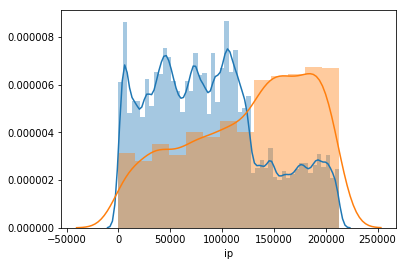

In [7]:
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
sns.distplot(X_train['ip'])
sns.distplot(X_train['ip'][X_train['is_attributed']==1])

#### Variable device

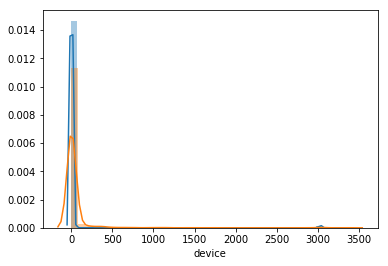

In [8]:
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
sns.distplot(X_train['device'])
sns.distplot(X_train['device'][X_train['is_attributed']==1])

#### Variable os

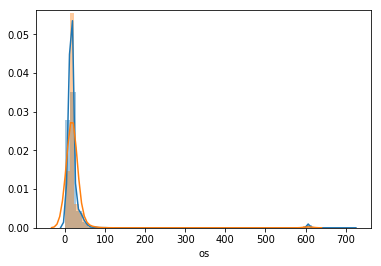

In [9]:
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
sns.distplot(X_train['os'])
sns.distplot(X_train['os'][X_train['is_attributed']==1])

#### Variable app

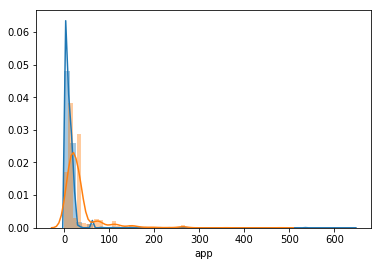

In [10]:
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
sns.distplot(X_train['app'])
sns.distplot(X_train['app'][X_train['is_attributed']==1])

#### Variable channel

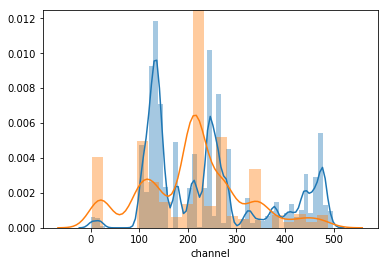

In [11]:
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
sns.distplot(X_train['channel'])
sns.distplot(X_train['channel'][X_train['is_attributed']==1])

#### Variable hour

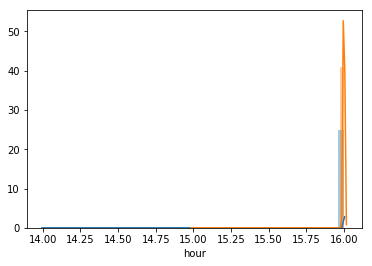

In [12]:
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
sns.distplot(X_train['hour'])
sns.distplot(X_train['hour'][X_train['is_attributed']==1])

#### Variable minute

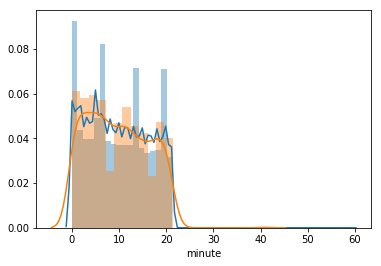

In [13]:
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
sns.distplot(X_train['minute'])
sns.distplot(X_train['minute'][X_train['is_attributed']==1])

#### Variable timePass

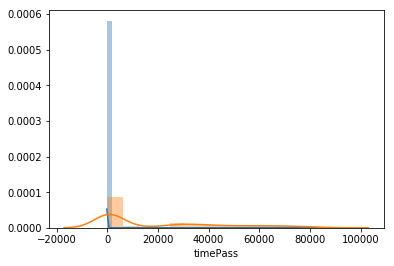

In [14]:
# Convertimos el tiempo pasado a entero para facilitar la representación
# Linea naranja indica el conjunto de ip con descargas, azul indica sin descarga
X_train['timePass'] = X_train['timePass'].fillna(0).astype(np.int64)
sns.distplot(X_train['timePass'])
sns.distplot(X_train['timePass'][X_train['is_attributed']==1])

**Curiosamente podemos observar como la mayoría de las clics que supusieron descargas son aquellas en las que el tiempo transcurrido es breve. Por tanto, debemos de prestarle bastante atención a esta variable.**

### 2.3. Correlación entre variables

En la correlación no interviene la variable tiempo de descarga, ya que este estudio se debería de realizar teniendo en cuenta únicamente las filas descargadas.

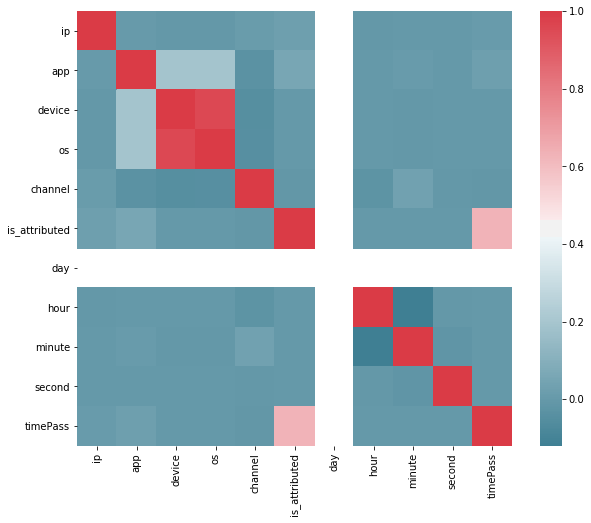

In [15]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

_Estas correlaciones nos muestran que existen corelaciónes entre la __app, os y device__. Algo que se puede considerar coherente, ya que algunas app son para un os determinado, y algunos os están asociadas a un tipo de device determinado, por ejemplo iOs con Apple_

### 2.4. Nivel de aportación con respecto a is_attributed

Posiblemente algunos valores de las variables como son ip, apps, devices etc. posiblemente tengan una frecuencia más alta de ser descargada, por tanto, se procede al calculo de la probabilidad de ser descargado: 
\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category)}
\end{equation}

o en ocasiones dos o multiples pares de combinaciones:
\begin{equation}
\text{P}\,\text{(is_attributed}\,\,|\,\,\text{category_1, category_2)}
\end{equation}

El peligro que tenemos es que si una combinación de categorias tiene muy pocos clics, entonces el peso estadistico de las ecucaciones de arriban se veran mermados, por tanto, introducimos el siguiente metodo de ponderación:
\begin{equation}
    \text{conf}_{\text{is_attributed}} = \frac{\log(\text{views}_{\text{category_1}})}{\log(100000)}
\end{equation}

donde el valor 100000 ha sido elegido arbitrariamente, de manera que si una categoria dada tienes 1000 apariciones, tiene un peso del 60% y si tiene 100 un peso del 40%

In [16]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['ip'], ['app'], ['device'], ['os'], ['channel'], ['hour'],['minute'],['timePass'],
    
    # V2 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    
    # V3 Features #
    ###############
    ['channel', 'os'],
    ['channel', 'device'],
    ['channel', 'timePass'],
    ['os', 'device'],
    
    # V4 Features #
    ###############
    ['app', 'channel'],
    ['app', 'os'],
    ['app', 'device'],
    ['app', 'timePass'],
    
    # V5 Features #
    ###############
    ['channel', 'timePass','app'],
    
]


# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = X_train.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))
    
    # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf
    
    # Perform the merge
    X_train = X_train.merge(
        group_object['is_attributed']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_attributed': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )
    
X_train.head()

>> Calculating confidence-weighted rate for: ['ip'].
   Saving to: ip_confRate. Group Max /Mean / Median / Min: 6437 / 25.25 / 10.0 / 1
>> Calculating confidence-weighted rate for: ['app'].
   Saving to: app_confRate. Group Max /Mean / Median / Min: 141851 / 4672.9 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['device'].
   Saving to: device_confRate. Group Max /Mean / Median / Min: 938053 / 3355.7 / 1.0 / 1
>> Calculating confidence-weighted rate for: ['os'].
   Saving to: os_confRate. Group Max /Mean / Median / Min: 239642 / 6250.0 / 38.0 / 1
>> Calculating confidence-weighted rate for: ['channel'].
   Saving to: channel_confRate. Group Max /Mean / Median / Min: 92534 / 6493.51 / 1200.0 / 1
>> Calculating confidence-weighted rate for: ['hour'].
   Saving to: hour_confRate. Group Max /Mean / Median / Min: 999517 / 333333.33 / 435.0 / 48
>> Calculating confidence-weighted rate for: ['minute'].
   Saving to: minute_confRate. Group Max /Mean / Median / Min: 57990 / 17543.86 / 

ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaT   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaT   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaT   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaT   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaT   

   is_attributed  day  hour              ...                \
0              0    6    14              ...                 
1              0    6    14              ...                 
2              0    6    14              ...                 
3              0    6    14              ...                 
4              0    6    14              ...                 

   app_device_confRate_x  channel_os_confRate  channel_device_confRate  \
0               0.000444             0.000000                 0.000499   
1               0.000444             0.000235                 0.000499   
2               0.000444             0.000000                 0.000499   
3               0.000445             0.001835                 0.004109   
4               0.000444             0.000000                 0.000499   

   channel_timePass_confRate  os_device_confRate  app_channel_confRate_y  \
0                        0.0            0.001182                0.000360   
1                        0.0            0.001428                0.000360   
2                        0.0            0.001182                0.000360   
3                        0.0            0.001182                0.004164   
4                        0.0            0.001182                0.000360   

   app_os_confRate_y  app_device_confRate_y  app_timePass_confRate  \
0           0.000366               0.000444                    0.0   
1           0.000275               0.000444                    0.0   
2           0.000366               0.000444                    0.0   
3           0.000201               0.000445                    0.0   
4           0.000366               0.000444                    0.0   

   channel_timePass_app_confRate  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  

[5 rows x 33 columns]

### 2.5. Agrupando por agregación

Se han utilizado muchas caracteristicas que surgen como resultado de la agregación, como son count(), var(), mean()


In [17]:
# Define all the groupby transformations
GROUPBY_AGGREGATIONS = [
    
    # V1 - GroupBy Features #
    #########################    
    # Variance in day, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'day', 'agg': 'var'},
    # Variance in hour, for ip-app-os
    {'groupby': ['ip','app','os'], 'select': 'hour', 'agg': 'var'},
    # Variance in hour, for ip-day-channel
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count'},
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean'}, 
    
    # V2 - GroupBy Features #
    #########################
    # Average clicks on app by distinct users; is it an app they return to?
    {'groupby': ['app'], 
     'select': 'ip', 
     'agg': lambda x: float(len(x)) / len(x.unique()), 
     'agg_name': 'AvgViewPerDistinct'
    },
    # How popular is the app or channel?
    {'groupby': ['app'], 'select': 'channel', 'agg': 'count'},
    {'groupby': ['channel'], 'select': 'app', 'agg': 'count'},
    
    # V3 - GroupBy Features                                              #
    # https://www.kaggle.com/bk0000/non-blending-lightgbm-model-lb-0-977 #
    ###################################################################### 
    {'groupby': ['ip'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','day'], 'select': 'hour', 'agg': 'nunique'}, 
    {'groupby': ['ip','app'], 'select': 'os', 'agg': 'nunique'}, 
    {'groupby': ['ip'], 'select': 'device', 'agg': 'nunique'}, 
    {'groupby': ['app'], 'select': 'channel', 'agg': 'nunique'}, 
    {'groupby': ['ip', 'device', 'os'], 'select': 'app', 'agg': 'nunique'}, 
    {'groupby': ['ip','device','os'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'app', 'agg': 'cumcount'}, 
    {'groupby': ['ip'], 'select': 'os', 'agg': 'cumcount'}, 
    {'groupby': ['ip','day','channel'], 'select': 'hour', 'agg': 'var'},
    
    # V4 - GroupBy Features #
    #########################
    # Teniendo en cuenta el tiempo transcurrido entre clics
    {'groupby': ['timePass'], 'select': 'channel', 'agg': 'nunique'},
    {'groupby': ['timePass','channel'], 'select': 'app', 'agg': 'nunique'},
    {'groupby': ['timePass','channel'], 'select': 'os', 'agg': 'cumcount'},
    {'groupby': ['timePass','channel', 'hour'], 'select': 'minute', 'agg': 'cumcount'},
    {'groupby': ['timePass','channel', 'minute'], 'select': 'hour', 'agg': 'cumcount'},
    {'groupby': ['timePass','channel', 'ip'], 'select': 'app', 'agg': 'cumcount'},
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:
    
    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']
    
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])
    
    # Info
    print("Grouping by {}, and aggregating {} with {}".format(
        spec['groupby'], spec['select'], agg_name
    ))
    
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    
    # Perform the groupby
    gp = X_train[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})
        
    # Merge back to X_total
    if 'cumcount' == spec['agg']:
        X_train[new_feature] = gp[0].values
    else:
        X_train = X_train.merge(gp, on=spec['groupby'], how='left')
        
     # Clear memory
    del gp
    gc.collect()

X_train.head()

Grouping by ['ip', 'app', 'channel'], and aggregating day with var
Grouping by ['ip', 'app', 'os'], and aggregating hour with var
Grouping by ['ip', 'day', 'channel'], and aggregating hour with var
Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
Grouping by ['app'], and aggregating ip with AvgViewPerDistinct
Grouping by ['app'], and aggregating channel with count
Grouping by ['channel'], and aggregating app with count
Grouping by ['ip'], and aggregating channel with nunique
Grouping by ['ip'], and aggregating app with nunique
Grouping by ['ip', 'day'], and aggregating hour with nunique
Grouping by ['ip', 'app'], and aggregating os with nunique
Grouping by ['ip'], and aggregating device with nu

ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaT   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaT   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaT   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaT   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaT   

   is_attributed  day  hour                ...                 \
0              0    6    14                ...                  
1              0    6    14                ...                  
2              0    6    14                ...                  
3              0    6    14                ...                  
4              0    6    14                ...                  

   ip_device_os_cumcount_app  ip_cumcount_app  ip_cumcount_os  \
0                          0                0               0   
1                          0                0               0   
2                          0                0               0   
3                          0                0               0   
4                          0                0               0   

   ip_day_channel_var_hour_y  timePass_nunique_channel  \
0                   1.333333                       154   
1                   1.000000                       154   
2                   2.000000                       154   
3                   1.000000                       154   
4                        NaN                       154   

   timePass_channel_nunique_app  timePass_channel_cumcount_os  \
0                             6                             0   
1                             6                             1   
2                             6                             2   
3                             2                             0   
4                             6                             3   

   timePass_channel_hour_cumcount_minute  \
0                                      0   
1                                      1   
2                                      2   
3                                      0   
4                                      3   

   timePass_channel_minute_cumcount_hour  timePass_channel_ip_cumcount_app  
0                                      0                                 0  
1                                      0                                 0  
2                                      0                                 0  
3                                      0                                 0  
4                                      0                                 0  

[5 rows x 61 columns]

### 2.6. Momento del siguiente clic

Creo que resultaría interesante saber cuanto tiempo suponer para una determinada ip, app y canal obtener el siguiente clic. Así que vamos a crear características para ellos también

In [18]:
GROUP_BY_NEXT_CLICKS = [
    
    # V1
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    
    # V2
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']},
    
     # V3
    {'groupby': ['ip', 'app', 'device', 'os', 'channel','timePass']},
    {'groupby': ['ip', 'channel', 'timePass']},
    {'groupby': ['ip', 'app', 'timePass']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    X_train[new_feature] = X_train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
X_train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel'], and saving time to next click in: ip_app_device_os_channel_nextClick
>> Grouping by ['ip', 'os', 'device'], and saving time to next click in: ip_os_device_nextClick
>> Grouping by ['ip', 'os', 'device', 'app'], and saving time to next click in: ip_os_device_app_nextClick
>> Grouping by ['ip', 'app', 'device', 'os', 'channel', 'timePass'], and saving time to next click in: ip_app_device_os_channel_timePass_nextClick
>> Grouping by ['ip', 'channel', 'timePass'], and saving time to next click in: ip_channel_timePass_nextClick
>> Grouping by ['ip', 'app', 'timePass'], and saving time to next click in: ip_app_timePass_nex

ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaT   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaT   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaT   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaT   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaT   

   is_attributed  day  hour            ...              ip_nextClick  \
0              0    6    14            ...                    5290.0   
1              0    6    14            ...                    5177.0   
2              0    6    14            ...                    5175.0   
3              0    6    14            ...                    5108.0   
4              0    6    14            ...                       NaN   

   ip_app_nextClick  ip_channel_nextClick  ip_os_nextClick  \
0            5340.0                5444.0           5307.0   
1            5177.0                5177.0           5239.0   
2            5175.0                6005.0           5205.0   
3            5110.0                5137.0           5108.0   
4               NaN                   NaN              NaN   

   ip_app_device_os_channel_nextClick  ip_os_device_nextClick  \
0                                 NaN                  5307.0   
1                                 NaN                  5239.0   
2                                 NaN                  5205.0   
3                                 NaN                  5108.0   
4                                 NaN                     NaN   

   ip_os_device_app_nextClick  ip_app_device_os_channel_timePass_nextClick  \
0                      5340.0                                          NaN   
1                      5547.0                                          NaN   
2                      5925.0                                          NaN   
3                      5110.0                                          NaN   
4                         NaN                                          NaN   

   ip_channel_timePass_nextClick  ip_app_timePass_nextClick  
0                         5444.0                     5340.0  
1                         5177.0                     5177.0  
2                         6005.0                     5175.0  
3                         5137.0                     5110.0  
4                            NaN                        NaN  

[5 rows x 71 columns]

### 2.7. Clics en un anuncio de app ¿Que pasó antes y después?

¿El usuario previamente en una subsecuencia ha clicado en la misma app-device-os-channel? Vamos a crear una característica para ello.

In [19]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    X_train['prev_'+fname] = X_train. \
        groupby(fset). \
        cumcount(). \
        rename('prev_'+fname)
        
    # Clicks in the future
    X_train['future_'+fname] = X_train.iloc[::-1]. \
        groupby(fset). \
        cumcount(). \
        rename('future_'+fname).iloc[::-1]

# Count cumulative subsequent clicks
X_train.head()

ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaT   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaT   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaT   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaT   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaT   

   is_attributed  day  hour        ...          \
0              0    6    14        ...           
1              0    6    14        ...           
2              0    6    14        ...           
3              0    6    14        ...           
4              0    6    14        ...           

   ip_app_device_os_channel_nextClick  ip_os_device_nextClick  \
0                                 NaN                  5307.0   
1                                 NaN                  5239.0   
2                                 NaN                  5205.0   
3                                 NaN                  5108.0   
4                                 NaN                     NaN   

   ip_os_device_app_nextClick  ip_app_device_os_channel_timePass_nextClick  \
0                      5340.0                                          NaN   
1                      5547.0                                          NaN   
2                      5925.0                                          NaN   
3                      5110.0                                          NaN   
4                         NaN                                          NaN   

   ip_channel_timePass_nextClick  ip_app_timePass_nextClick  \
0                         5444.0                     5340.0   
1                         5177.0                     5177.0   
2                         6005.0                     5175.0   
3                         5137.0                     5110.0   
4                            NaN                        NaN   

   prev_identical_clicks  future_identical_clicks  prev_app_clicks  \
0                      0                        0                0   
1                      0                        0                0   
2                      0                        0                0   
3                      0                        0                0   
4                      0                        0                0   

   future_app_clicks  
0                 18  
1                 22  
2                  9  
3                 68  
4                  0  

[5 rows x 75 columns]

### 3. Evaluando importancia de las caracteristicas

Teniendo creadas las características de arriba entrenaremos usando xgBoost los data. Primeramente dividimos en Y y x

In [20]:
# Comprobamos que los datos son adecuados para aplicar el modelo
X_train.dtypes

ip                                                      int64
app                                                     int64
device                                                  int64
os                                                      int64
channel                                                 int64
click_time                                     datetime64[ns]
attributed_time                                datetime64[ns]
is_attributed                                           int64
day                                                     uint8
hour                                                    uint8
minute                                                  uint8
second                                                  uint8
timePass                                                int64
ip_confRate                                           float64
app_confRate                                          float64
device_confRate                                       float64
os_confR

In [21]:
import xgboost as xgb

# Split into X and y
y = X_train['is_attributed']
X = X_train.drop('is_attributed', axis=1).select_dtypes(include=[np.number])

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=0, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=4, reg_lambda=1, scale_pos_weight=9, seed=None,
       silent=True, subsample=0.8)

La importancia de las caracteristicas son los escalados MinMax, puestos dentro de un Dataframe , y finalmente imprimidos por orde de la media de importancia por caracteristica

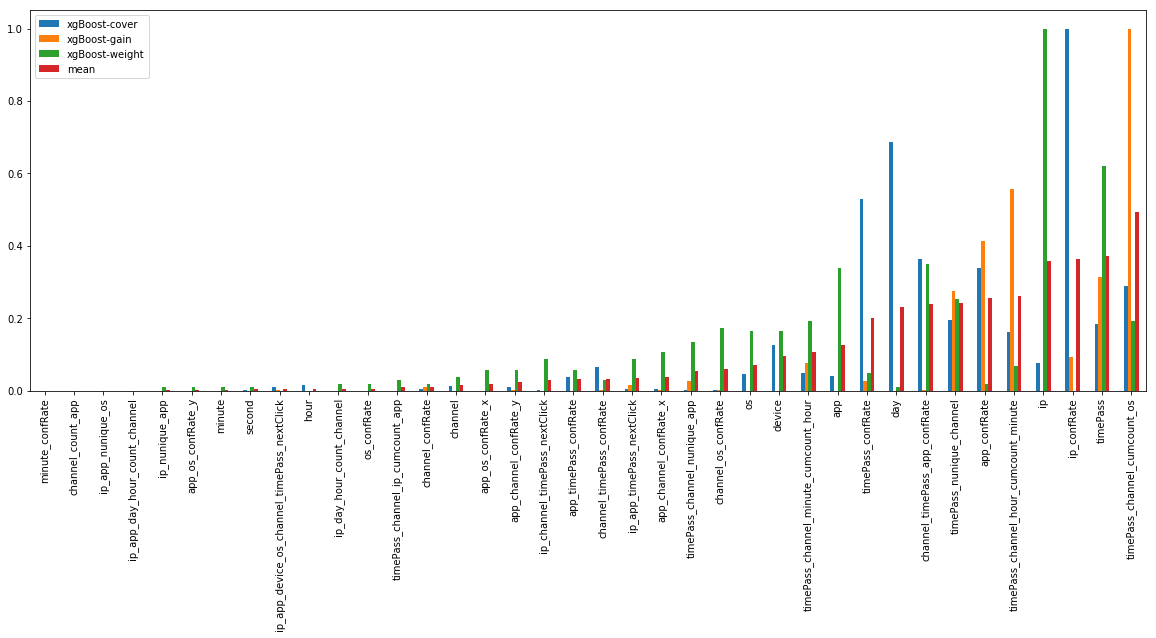

In [22]:
from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

Las dos agrupaciones que ofrecen más relevancia son: tiempo transcurrido en la descarga y la conjunción app, con canal, por tanto vamos a intentar

### 4. Estudio referente únicamente a las descargas (is_attributed==1)

In [23]:
# Cargamos de nuevo el dataset
X_train = pd.read_csv('./input/train.csv', nrows=1000000, parse_dates=['click_time'])

# Trabajando con un subconjunto de datos más pequeño
rows = X_train[X_train['is_attributed']==1].index.values
X_train_attributed = X_train.loc[rows]

In [24]:
# Medidas resumen del conjunto
X_train_attributed.describe()

ip          app       device           os      channel  \
count    1693.000000  1693.000000  1693.000000  1693.000000  1693.000000   
mean   124243.870644    34.372711    39.694034    22.381571   209.923804   
std     59643.785434    41.204987   241.120549    48.520508   103.391865   
min        39.000000     0.000000     0.000000     0.000000     3.000000   
25%     77048.000000    18.000000     1.000000    13.000000   134.000000   
50%    135487.000000    19.000000     1.000000    19.000000   213.000000   
75%    175005.000000    35.000000     1.000000    24.000000   274.000000   
max    212767.000000   481.000000  3379.000000   607.000000   489.000000   

       is_attributed  
count         1693.0  
mean             1.0  
std              0.0  
min              1.0  
25%              1.0  
50%              1.0  
75%              1.0  
max              1.0

#### 4.1. Obtenemos los elementos únicos de cada variable

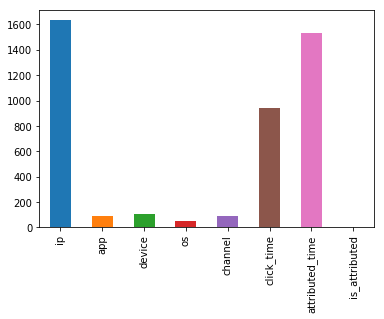

In [25]:
# contamos los elementos únicos de cada variable
t_unique = X_train_attributed.nunique()
t_unique.plot(kind='bar')

_La estructura de variables con elementos únicos sigue la misma forma que con todo el subconjunto estudiado con anterioridad._

#### 4.2. Extración de caracteristicas

In [26]:
# Extración de caracteristicas de click_time (día, hora, minuto y segundo)
X_train_attributed['day'] = X_train_attributed['click_time'].dt.day.astype('uint8')
X_train_attributed['hour'] = X_train_attributed['click_time'].dt.hour.astype('uint8')
X_train_attributed['minute'] = X_train_attributed['click_time'].dt.minute.astype('uint8')
X_train_attributed['second'] = X_train_attributed['click_time'].dt.second.astype('uint8')

# Extración de la caracteristica del tiempo transcurrido hasta la descarga
X_train_attributed['click_time'] = pd.to_datetime(X_train_attributed['click_time'])
X_train_attributed['attributed_time'] = pd.to_datetime(X_train_attributed['attributed_time'])
X_train_attributed['timePass']= X_train_attributed['attributed_time']-X_train_attributed['click_time']

# Convertimos timePass to float y comparamos que todos los tipos son adecuados para llevar a cabo el algoritmo
X_train_attributed['timePass'] = X_train_attributed['timePass'].dt.total_seconds()

#### 4.3. Histograma de cada variable

##### Variable IP

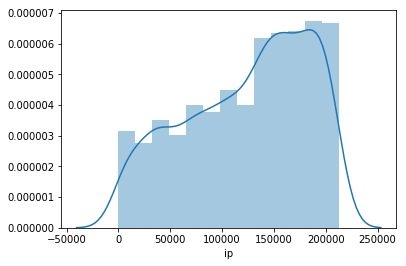

In [27]:
sns.distplot(X_train_attributed['ip'])

##### Variable device

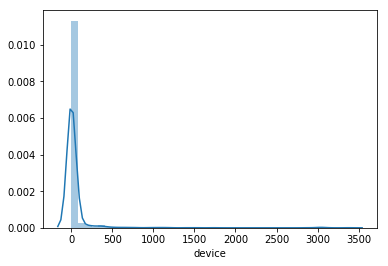

In [28]:
sns.distplot(X_train_attributed['device'])

##### Variable os

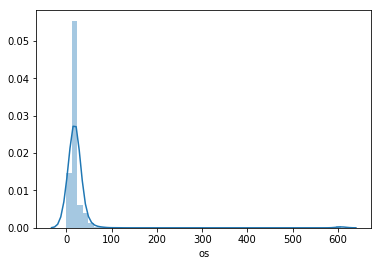

In [29]:
sns.distplot(X_train_attributed['os'])

##### Variable app

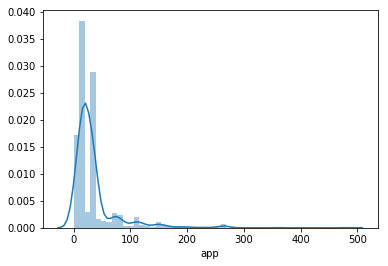

In [30]:
sns.distplot(X_train_attributed['app'])

##### Variable channel

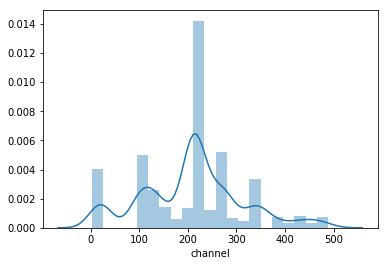

In [31]:
sns.distplot(X_train_attributed['channel'])

##### Variable hour

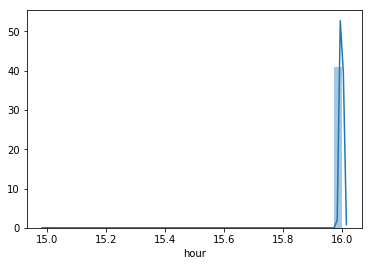

In [32]:
sns.distplot(X_train_attributed['hour'])

##### Variable minute

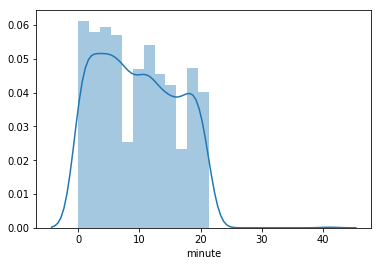

In [33]:
sns.distplot(X_train_attributed['minute'])

##### Variable timePass

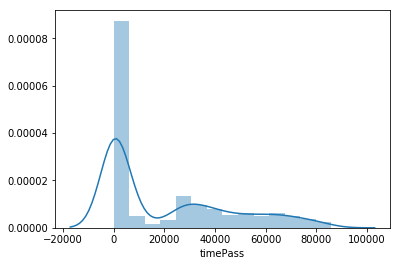

In [34]:
sns.distplot(X_train_attributed['timePass'])

#### 4.4. Correlación entre variables

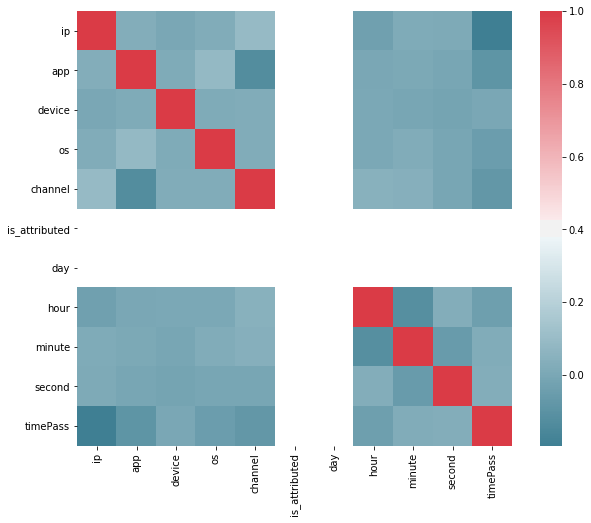

In [35]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X_train_attributed.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

_Como resultado de esta correlación vemos que no existe ninguna dependencia fuerte entre variables_